# PROJET VALEO : CLASSIFICATION


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.feature_selection import SelectKBest, f_classif  # variables ayant le lien le plus fort avec la target dans un test de anova
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline 

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 100)
%pwd

'C:\\Users\\pierr\\VALEO PROJECT'

# Chargement du dataset :

In [2]:
X=pd.read_csv('traininginputs.csv')
y=pd.read_csv('trainingoutput.csv')
X_true=pd.read_csv('testinputs.csv') 

# Suppression des colonnes inutiles

In [3]:
X=X.drop('PROC_TRACEINFO',axis=1)#la colonne "nom" est inutile
y=y.drop('PROC_TRACEINFO',axis=1)
X_true=X_true.drop('PROC_TRACEINFO',axis=1)

col=X.columns

# On crée train et test :
En vérifiant l' équilibre.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
y_train.value_counts()


Binar OP130_Resultat_Global_v
0                                27374
1                                  238
dtype: int64

In [5]:
y_test.value_counts()

Binar OP130_Resultat_Global_v
0                                6836
1                                  67
dtype: int64

# Preprocessing : imputation NaN, normalisation avant le sampling sur le train)

In [6]:
imputer=X_train['OP100_Capuchon_insertion_mesure'].median()


def imputation(X_train, X_test, X_true): #sur toutes
    X_train.loc[:,'OP100_Capuchon_insertion_mesure'] = X_train.loc[:,'OP100_Capuchon_insertion_mesure'] .fillna(imputer)
    X_test.loc[:,'OP100_Capuchon_insertion_mesure'] = X_test.loc[:,'OP100_Capuchon_insertion_mesure'].fillna(imputer)
    X_true.loc[:,'OP100_Capuchon_insertion_mesure'] = X_true.loc[:,'OP100_Capuchon_insertion_mesure'] .fillna(imputer)
    return X_train, X_test, X_true

X_train, X_test, X_true= imputation(X_train, X_test, X_true)   


C:\Users\pierr\anaconda3\lib\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [7]:
def normalize(X_train, X_test, X_true): #sur toutes
    scaler = StandardScaler()
    scaler.fit(X_train) 

    X_train= scaler.transform(X_train) 
    X_test= scaler.transform(X_test)  
    X_true=scaler.transform(X_true)
    
    X_train=pd.DataFrame(X_train, columns=col)
    X_test=pd.DataFrame(X_test, columns=col)
    X_true=pd.DataFrame(X_true, columns=col)
    
    return X_train, X_test, X_true


X_train, X_test, X_true=normalize(X_train, X_test, X_true)  

In [8]:
def sampling(X_train, y_train): #sur le train 
    X_train,y_train= ADASYN().fit_sample(X_train,y_train)
    df=pd.concat([X_train,y_train],axis=1)
    df=df.sample(frac=1)#shuffle sur les lignes
    X_train = df.drop('Binar OP130_Resultat_Global_v', axis=1)
    y_train = df['Binar OP130_Resultat_Global_v']
    return X_train, y_train


X_train, y_train= sampling(X_train, y_train)
X_train.shape

(54836, 13)

# Fonction d'évaluation et courbes d'apprentissage :

In [9]:
def evaluation(model,X,y,X_test,y_test):
                                      
    model.fit(X,y)
    
    #score sur le train
    ypred1=model.predict(X)
    score_train=roc_auc_score(y,ypred1)
    
    #score sur le test
    ypred2=model.predict(X_test)
    score_test=roc_auc_score(y_test,ypred2)
      
    
    return score_train, score_test

In [10]:
def courbes(model,X,y,X_test,y_test):
    tailles=[10,1000,5000,10000,27000,50000]
    
    liste_train=[]
    liste_test=[]
    
    for i in tailles:     
        a,b=evaluation(model,X[0:i],y[0:i],X_test,y_test)
        liste_train.append(a)
        liste_test.append(b)

   
    
    plt.figure()
    plt.plot(tailles,liste_test, label='test')
    plt.plot(tailles,liste_train,label='train')
    plt.legend()

# Essai d'un model simplissime
Arbre de décision->overfit

(1.0, 0.5128064330192221)


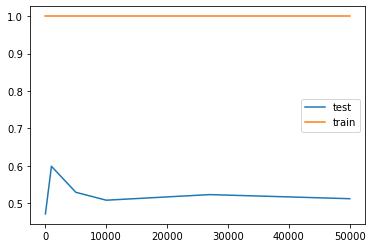

In [11]:
tree=DecisionTreeClassifier(random_state=0)#max_depth à optimiser

print(evaluation(tree,X_train,y_train,X_test,y_test))

courbes(tree,X_train,y_train,X_test,y_test)

<AxesSubplot:>

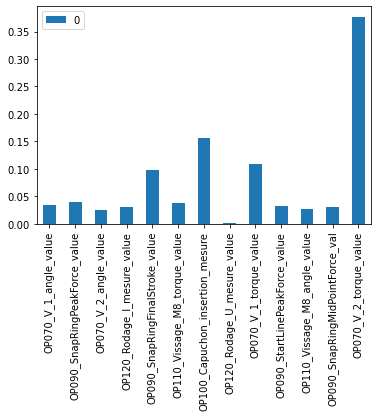

In [173]:
pd.DataFrame(tree.feature_importances_, index=X_train.columns).plot.bar()

# Essai d un modèle simple régularisé 
random forest-> overfit


(1.0, 0.5073164021903357)


<AxesSubplot:>

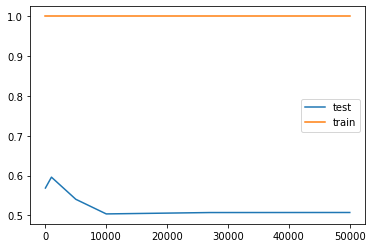

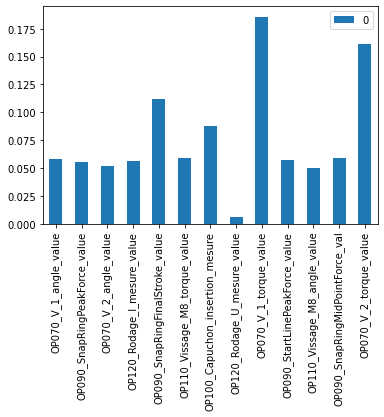

In [204]:
forest=RandomForestClassifier(random_state=0)

print(evaluation(forest,X_train,y_train,X_test,y_test))

courbes(forest,X_train,y_train,X_test,y_test)

pd.DataFrame(forest.feature_importances_, index=X_train.columns).plot.bar()

# Essai simple de logistic regression
high bias

(0.6444107198785127, 0.6014536737028724)


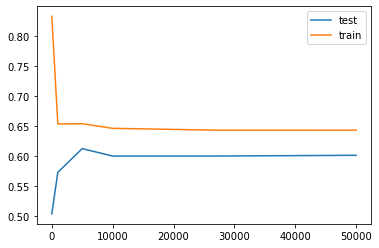

In [12]:
lr=LogisticRegression(random_state=0)

print(evaluation(lr,X_train,y_train,X_test,y_test))

courbes(lr,X_train,y_train,X_test,y_test)


# PLUS SYSTEMATIQUE :  comparaison de plusieurs modèles
beaucoup d'overfitting :
-simplifier les modèles (moins de depth?)
-davantage d'exemples (difficile)
-simplifier le train (kbest? pca?)
-constante de régularisation

In [14]:
#liste de modèles
tree=DecisionTreeClassifier(random_state=0)  #overfit
forest=RandomForestClassifier(random_state=0)#overfit
ada=AdaBoostClassifier(random_state=0)       #overfit
KNN=KNeighborsClassifier()                   #overfit
LR= LogisticRegression(random_state=0)       #underfit
SVM=SVC(random_state=0)                      #overfit
xc=xgb.XGBClassifier()                       #overfit
xr=xgb.XGBRegressor()                        #overfit
nb=GaussianNB()                              #overfit
#multivariate gaussian





(1.0, 0.5297797874291503)
(0.8791719151899196, 0.5535684654550534)
(0.6459042772904467, 0.6007953940071439)
(0.6482819778459176, 0.5417630979100984)
(0.9998686562227286, 0.5649589967075098)


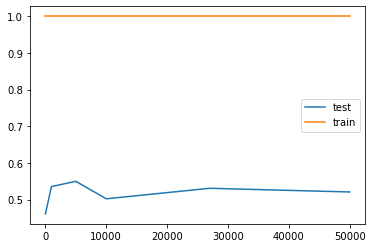

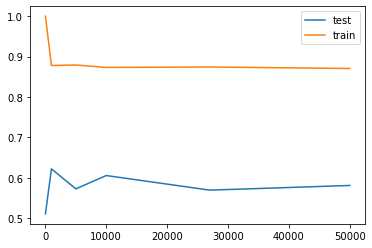

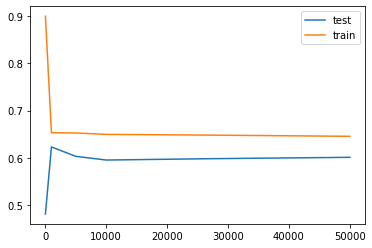

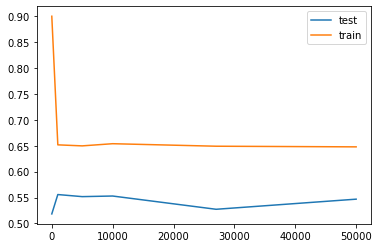

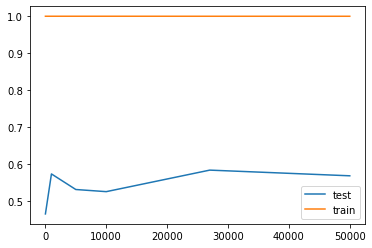

In [177]:
list_of_models=[tree,ada,LR,nb,xr] #remarque : on peut faire mieux avec un dictionnaire

for model in list_of_models:
    print(evaluation(model,X_train,y_train,X_test,y_test))
    courbes(model,X_train,y_train,X_test,y_test)   

# On crée des pipelines pour contrer l'overfiting (ou undefitting pour LR)

In [73]:
list_of_models=[tree,forest,ada,xr,xc,LR,SVM] #remarque : on peut faire mieux avec un dictionnaire

for model in list_of_models:
    pipe_overfiting=make_pipeline(SelectKBest(f_classif,k=4),model)
    print(evaluation(pipe_overfiting,X_train,y_train,X_test,y_test))

(0.9919814422444655, 0.50687754905985)
(0.9919631767370497, 0.4996342890579286)
(0.8812194052750786, 0.5747087412556876)
(0.998309890076583, 0.6745052531374724)
[09:37:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


(0.9911777599181706, 0.49992685781158575)
(0.6032731789289106, 0.5797195269992926)
(0.6713852560824138, 0.6562524562675213)


In [15]:
pipe_underfiting=make_pipeline(PolynomialFeatures(2),LR)
print(evaluation(pipe_underfiting,X_train,y_train,X_test,y_test))

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.7424200312513507, 0.5642821585460642)


# Courbes du meilleur modèle: xgb regressor

(0.9983145815970726, 0.7032654166266386)


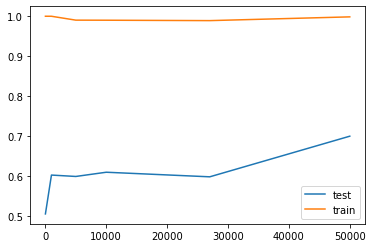

In [16]:
pipe_xgbr=make_pipeline(SelectKBest(f_classif,k=4),xr)

print(evaluation(pipe_xgbr,X_train,y_train,X_test,y_test))
courbes(pipe_xgbr,X_train,y_train,X_test,y_test)

# Optimisation des hyper paramètres par gridsearch custom:
à cause du SMOTE, les cross validations sont biaisées et les résultats de gridsearchCV faussés (train trop homogène).
(Pas de randomizedsearchpossible)

In [83]:
pipe_xgbr

Pipeline(steps=[('selectkbest', SelectKBest(k=4)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [17]:
def grid_search_custom(X_train,y_train,X_test,y_test):
    
    #paramètres
    k_liste=range(2,10)
    depth_liste=[2,4,8,16]
    rate_liste=[0.0001, 0.001, 0.01, 0.1,1]
    
    #initialisations:
    meilleur_k=2
    meilleur_depth=2
    meilleur_rate=0.001
    meilleur_score=0
    
    for r in rate_liste:
        for d in depth_liste:
            for kb in k_liste:
                pipe_xgbr=make_pipeline(SelectKBest(f_classif,k=kb),xgb.XGBRegressor(learning_rate=r ,max_depth=d) )
                a,b=evaluation(pipe_xgbr,X_train,y_train,X_test,y_test)
                if b > meilleur_score:
                    meilleur_score=b
                    meilleur_k=kb
                    meilleur_depth=d
                    meilleur_rate=r
                    meilleur_modele=pipe_xgbr

    print('meilleur k:',meilleur_k)
    print('meilleur score:',meilleur_score)
    print('meilleur depth:',meilleur_depth)
    print('meilleur rate:',meilleur_rate)
    return meilleur_modele

meilleur_modele=grid_search_custom(X_train,y_train,X_test,y_test)

meilleur k: 4
meilleur score: 0.6711920211697511
meilleur depth: 4
meilleur rate: 1


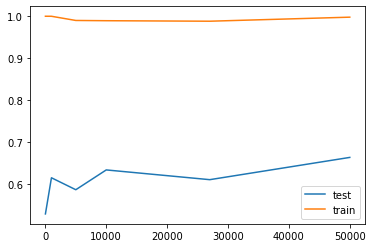

In [18]:
courbes(meilleur_modele,X_train,y_train,X_test,y_test)

# Mise au bon format de ypred pour la compétion.

In [221]:
ypred=meilleur_modele.predict(X_true)
ypred=ypred>0.5


#obligatoire : FINAL on met la submission au bon format car on veut un dataframe 2 colonnes
df_out=pd.read_csv('Random_Submission_format.csv')
df_out['Binar OP130_Resultat_Global_v']=ypred

#exporter en csv une dataframe
df_out.to_csv('prediction finale valeo 16 01' ,index=False)

print(df_out)


                  PROC_TRACEINFO  Binar OP130_Resultat_Global_v
0     I-B-XA1207672-190520-00632                          False
1     I-B-XA1207672-190508-03689                          False
2     I-B-XA1207672-190715-00577                          False
3     I-B-XA1207672-190503-00796                          False
4     I-B-XA1207672-190712-01837                          False
...                          ...                            ...
7996  I-B-XA1207672-190905-03031                          False
7997  I-B-XA1207672-190531-00225                          False
7998  I-B-XA1207672-190424-03040                          False
7999  I-B-XA1207672-190715-00155                          False
8000  I-B-XA1207672-190503-00995                          False

[8001 rows x 2 columns]


,PROC_TRACEINFO,Binar OP130_Resultat_Global_v
count,8001,8001
unique,8001,2
top,I-B-XA1207672-190829-00668,False
freq,1,7946


# -------------------------------Notes perso ne pas lire--------------------------------------------


# Création d'une gaussianne multivariate à la main

In [ ]:
def multi_gaussian(X, exemple_X)
    return p(exemple)

def trouve_seuil(X,y):
    return meilleur seuil

alpha=trouve_seuil(X,y)

def prediction(exemple):
    return multi_gaussian(X)>alpha


(0.9858474629025297, 0.6475408941250447)


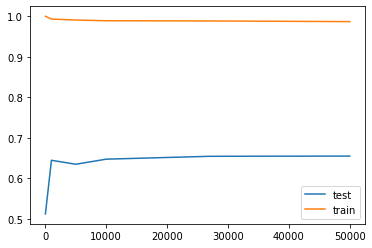

In [20]:
xgbR=xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.111189,max_depth = 5, alpha = 1, n_estimators =30)

print(evaluation(xgbR,X_train,y_train,X_test,y_test))

courbes(xgbR,X_train,y_train,X_test,y_test)
